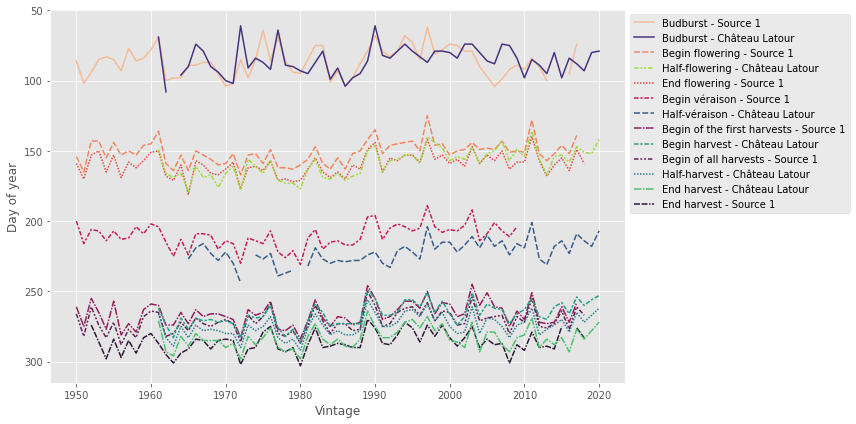

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 4)

pheno_1 = pd.read_excel('data/pheno/pheno_TL.xlsx', index_col=0).rename(columns=
            {
                'Pousse de la vigne':'Budburst - Source 1',
                'Première fleur':'Begin flowering - Source 1',
                'Pleine fleur':'End flowering - Source 1',
                'Premiers grains changés':'Begin véraison - Source 1',
                'Début vendanges (en Médoc)':'Begin of the first harvests - Source 1',
                'Pleines vendanges':'Begin of all harvests - Source 1',
                'Fin vendanges rouges':'End harvest - Source 1',
            })
pheno_1 = pheno_1.iloc[:, :7]
cols = list(pheno_1.columns)
years = list(pheno_1.index)
pheno_1_plot = pheno_1.copy()

for col in cols:
    pheno_1[col] = pd.to_datetime(pheno_1[col], errors='coerce')
    for year in years:
        try:
            pheno_1.loc[year, col] = pheno_1.loc[year, col].replace(year = year).normalize()
        except:
            continue
    pheno_1_plot[col] = pheno_1[col].dt.dayofyear

plt.figure(figsize=(12,6))
palette = sns.color_palette('rocket_r', 7)
sns.lineplot(data = pheno_1_plot, palette = palette)
    
pheno_2 = pd.read_excel('data/pheno/pheno_latour.xlsx', index_col=0).rename(columns=
            {
                'debourrement':'Budburst - Château Latour',
                'half-veraison':'Half-véraison - Château Latour',
                'half-vendanges':'Half-harvest - Château Latour',
                'begin vendanges':'Begin harvest - Château Latour',
                'end vendanges':'End harvest - Château Latour'
            })
pheno_2['Half-flowering - Château Latour'] = pheno_2['half-floraison M'] + (pheno_2['half-floraison CS'] - pheno_2['half-floraison M'])/2
pheno_2 = pheno_2.drop(['half-floraison M', 'half-floraison CS'], axis=1)
#pheno_2['floraison'] = pheno_2['mi-floraison M']
pheno_2_plot = pheno_2.copy()
for col in pheno_2.columns:
    pheno_2[col] = pd.to_datetime(pheno_2[col], errors='coerce')
    for year in years[11:]:
        try:
            pheno_2.loc[year, col] = pheno_2.loc[year, col].replace(year = year).normalize()
        except:
            continue
    pheno_2_plot[col] = pheno_2[col].dt.dayofyear

palette = sns.color_palette('viridis', 6)
plot = sns.lineplot(data=pheno_2_plot, palette=palette)
plot.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Day of year')
plt.xlabel('Vintage')
plt.tight_layout()
plt.gca().invert_yaxis()
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,7, 1, -1, 2, 3, 8, 4, -3, 5, -4, -2, 6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('views/pheno_both_sources.png')
plt.show()

From the above chart, several remarks:

- Debourrement dates seem incertain. TL debourrement should always be first, but it is not. Therefore the debourrement will be averaged between the two sources.
- "mi-floraison" in Source 2 seems to correspond to "pleine fleur" in Source 1. The latest date will be chosen for the "end floraison" parameter
- Missing values in begin and half veraison will be obtained by substracting or adding to the present value the mean difference between series.
- Latest and earliest records of any vendanges event will be kept for begin and end of vendanges

1961-09-17 00:00:00 1961-09-19 00:00:00
1962-10-01 00:00:00 1962-10-01 00:00:00
1963-10-01 00:00:00 1963-10-10 00:00:00
1964-09-21 00:00:00 1964-09-25 00:00:00
1965-09-30 00:00:00 1965-10-04 00:00:00
1966-09-20 00:00:00 1966-09-26 00:00:00
1967-09-25 00:00:00 1967-09-28 00:00:00
1968-09-22 00:00:00 1968-09-26 00:00:00
1969-09-23 00:00:00 1969-09-29 00:00:00
1970-09-25 00:00:00 1970-09-28 00:00:00
1971-09-27 00:00:00 1971-09-30 00:00:00
1972-10-09 00:00:00 1972-10-09 00:00:00
1973-09-20 00:00:00 1973-09-24 00:00:00
1974-09-24 00:00:00 1974-09-26 00:00:00
1975-09-22 00:00:00 1975-09-25 00:00:00
1976-09-13 00:00:00 1976-09-16 00:00:00
1977-10-04 00:00:00 1977-10-03 00:00:00
1978-10-05 00:00:00 1978-10-09 00:00:00
1979-10-01 00:00:00 1979-10-04 00:00:00
1980-10-10 00:00:00 1980-10-13 00:00:00
1981-09-28 00:00:00 1981-09-28 00:00:00
1982-09-13 00:00:00 1982-09-16 00:00:00
1983-09-26 00:00:00 1983-09-22 00:00:00
1984-10-01 00:00:00 1984-10-01 00:00:00
1985-09-25 00:00:00 1985-09-30 00:00:00


None

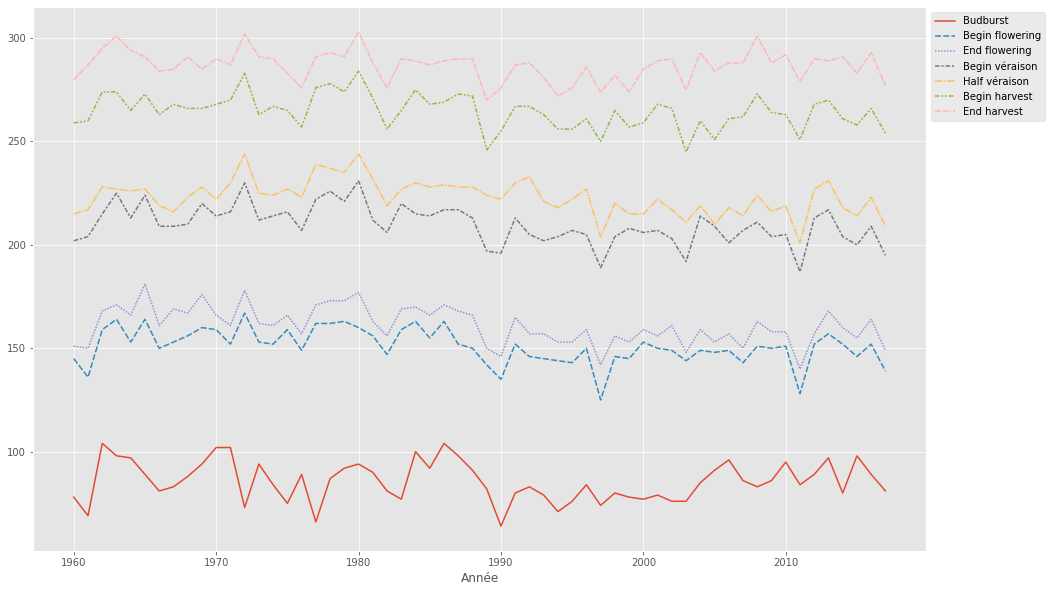

In [30]:
pheno_1 = pheno_1.loc[1960:2017]
pheno_2 = pheno_2.loc[1960:2017]

pheno_df = pd.DataFrame(np.zeros(len(pheno_1)), index = pheno_1.index).iloc[:, 1:]

### Budburst
# Calculate mean
pheno_df['Budburst'] = pheno_1['Budburst - Source 1'] + (pheno_2['Budburst - Château Latour'] - pheno_1['Budburst - Source 1'])/2
# Fill missing values with either only source 1 or only source 2
pheno_df['Budburst'] = pheno_df['Budburst'].fillna(pheno_2['Budburst - Château Latour']).fillna(pheno_1['Budburst - Source 1']).dt.normalize()



### Floraison
pheno_df['Begin flowering'] = pheno_1['Begin flowering - Source 1']

# For the end: get the later known date between end floraison and half-floraison
pheno_df['End flowering'] = np.nan
for year in pheno_df.index[1:]:
    date_1 = pheno_1.loc[year, 'End flowering - Source 1']
    date_2 = pheno_2.loc[year, 'Half-flowering - Château Latour']
    pheno_df.loc[year, 'End flowering'] = max(date_1, date_2)
pheno_df['End flowering'] = pheno_df['End flowering'].fillna(pheno_1['End flowering - Source 1'])\
                                                     .fillna(pheno_2['Half-flowering - Château Latour'])\
                                                     .dt.normalize()
    
### Veraison
average_veraison_delay = np.mean(pheno_2['Half-véraison - Château Latour'] - pheno_1['Begin véraison - Source 1'])
pheno_df['Begin véraison'] = pheno_1['Begin véraison - Source 1'].fillna(pheno_2['Half-véraison - Château Latour'] - average_veraison_delay).dt.normalize()
pheno_df['Half véraison'] = pheno_2['Half-véraison - Château Latour']
pheno_df['Half véraison'] = pheno_df['Half véraison'].fillna(pheno_1['Begin véraison - Source 1'] + average_veraison_delay).dt.normalize()


### Vendanges
# For the begin: get the earliest known date between the two sources
pheno_df['Begin harvest'] = pheno_1.loc[year, 'Begin of the first harvests - Source 1']
for year in pheno_df.index[1:]:
    date_1 = pheno_1.loc[year, 'Begin of the first harvests - Source 1']
    date_2 = pheno_2.loc[year, 'Begin harvest - Château Latour']
    pheno_df.loc[year, 'Begin harvest'] = min(date_1, date_2)
    print(date_1, date_2)
    
pheno_df.loc[1960, 'Begin harvest'] = pheno_1.loc[1960, 'Begin of the first harvests - Source 1']
pheno_df['Begin harvest'] = pheno_df['Begin harvest'].dt.normalize()
# For the end: get the later known date between the two sources
pheno_df['End harvest'] = np.nan
for year in pheno_df.index[1:]:
    date_1 = pheno_1.loc[year, 'End harvest - Source 1']
    date_2 = pheno_2.loc[year, 'End harvest - Château Latour']
    pheno_df.loc[year, 'End harvest'] = max(date_1, date_2)
pheno_df['End harvest'] = pheno_df['End harvest'].fillna(pheno_1['End harvest - Source 1'])\
                                                     .fillna(pheno_2['End harvest - Château Latour'])\
                                                     .dt.normalize()


display(pheno_df.info())
pheno_df_plot = pheno_df.copy()
for col in pheno_df_plot.columns:
    pheno_df_plot[col] = pheno_df_plot[col].dt.dayofyear
plt.figure(figsize=(16,10))
palette = sns.color_palette('viridis', 6)
sns.lineplot(data=pheno_df_plot)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig('views/pheno_full.png')
plt.show()

,Budburst,Begin flowering,End flowering,Begin véraison,Half véraison,Begin harvest,End harvest,Budburst - flowering interval,Flowering - véraison interval,Véraison - harvest interval,Growing season duration
Année,,,,,,,,,,,
1960,1960-03-18,1960-05-24,1960-05-30,1960-07-20,1960-08-02,1960-09-15,1960-10-06,67,64,44,181
1961,1961-03-10,1961-05-16,1961-05-30,1961-07-23,1961-08-05,1961-09-17,1961-10-14,67,67,43,191
1962,1962-04-14,1962-06-08,1962-06-17,1962-08-03,1962-08-16,1962-10-01,1962-10-22,55,60,46,170
1963,1963-04-08,1963-06-13,1963-06-20,1963-08-13,1963-08-15,1963-10-01,1963-10-28,66,56,47,176
1964,1964-04-06,1964-06-01,1964-06-14,1964-07-31,1964-08-13,1964-09-21,1964-10-20,56,60,39,168


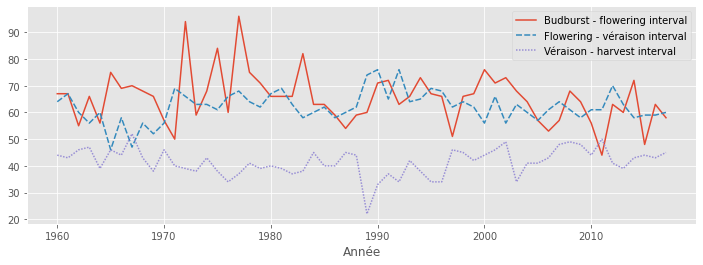

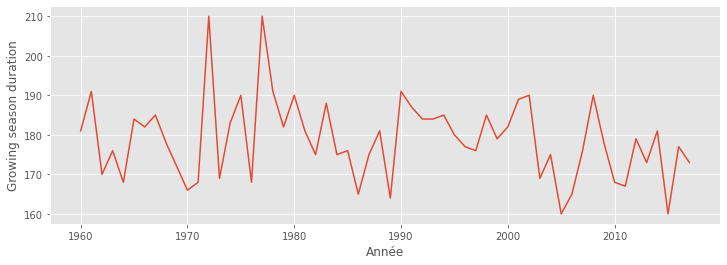

In [31]:
pheno_df['Budburst - flowering interval'] = (pheno_df['Begin flowering'] - pheno_df['Budburst']).dt.days
pheno_df['Flowering - véraison interval'] = (pheno_df['Half véraison'] - pheno_df['End flowering']).dt.days
pheno_df['Véraison - harvest interval'] = (pheno_df['Begin harvest'] - pheno_df['Half véraison']).dt.days
pheno_df['Growing season duration'] = (pheno_df['Begin harvest'] - pheno_df['Budburst']).dt.days
display(pheno_df.head())
sns.lineplot(data=pheno_df.iloc[:, -4:-1])
plt.show()

sns.lineplot(data=pheno_df.iloc[:, -1])
plt.show()
pheno_df.to_excel('data/generated_pheno.xlsx')